## Assignment 13 — Time Series Anomaly Detection (INFY Stock Data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [2]:
df = pd.read_csv("E:/Engineering/Machine Learning/ADS-VAC/notebooks/datasets/infy_stock.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()

df.head()


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,INFY,EQ,1972.55,1968.95,1982.00,1956.9,1971.00,1974.40,1971.34,500691,9.870306e+13,14908,258080,0.5154
2015-01-02,INFY,EQ,1974.40,1972.00,2019.05,1972.0,2017.95,2013.20,2003.25,1694580,3.394669e+14,54166,1249104,0.7371
2015-01-05,INFY,EQ,2013.20,2009.90,2030.00,1977.5,1996.00,1995.90,2004.59,2484256,4.979911e+14,82694,1830962,0.7370
2015-01-06,INFY,EQ,1995.90,1980.00,1985.00,1934.1,1965.10,1954.20,1954.82,2416829,4.724458e+14,108209,1772070,0.7332
2015-01-07,INFY,EQ,1954.20,1965.00,1974.75,1950.0,1966.05,1963.55,1962.59,1812479,3.557162e+14,62463,1317720,0.7270


### Manual Anomaly Visualization

### Plot Raw Close Price

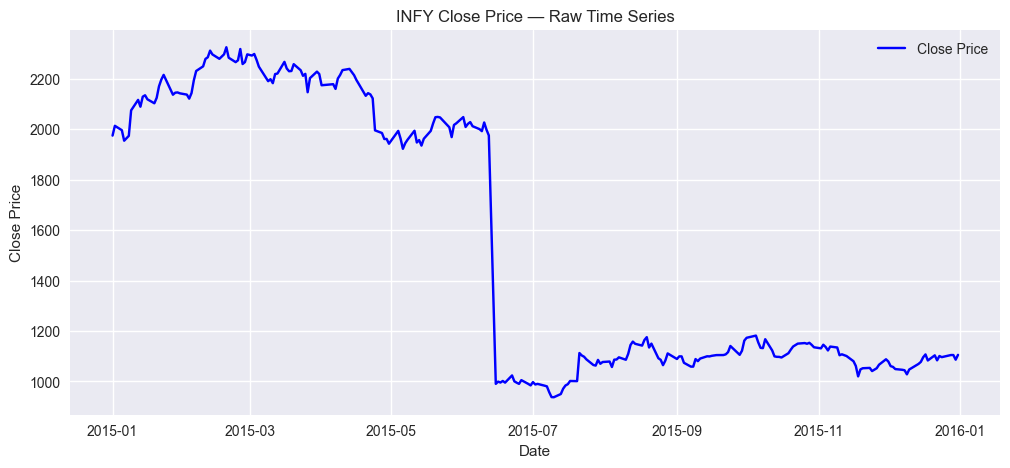

In [3]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"], label="Close Price", color='blue')
plt.title("INFY Close Price — Raw Time Series")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


### Rolling Mean & Rolling Std for Anomaly Detection (7 Days)

value > mean + 3*std  OR  value < mean - 3*std


In [4]:
window = 7

df["rolling_mean"] = df["Close"].rolling(window=window).mean()
df["rolling_std"] = df["Close"].rolling(window=window).std()


In [5]:
df["upper_band"] = df["rolling_mean"] + 3 * df["rolling_std"]
df["lower_band"] = df["rolling_mean"] - 3 * df["rolling_std"]

# Anomaly = outside 3σ control band
df["rolling_anomaly"] = (
    (df["Close"] > df["upper_band"]) |
    (df["Close"] < df["lower_band"])
)


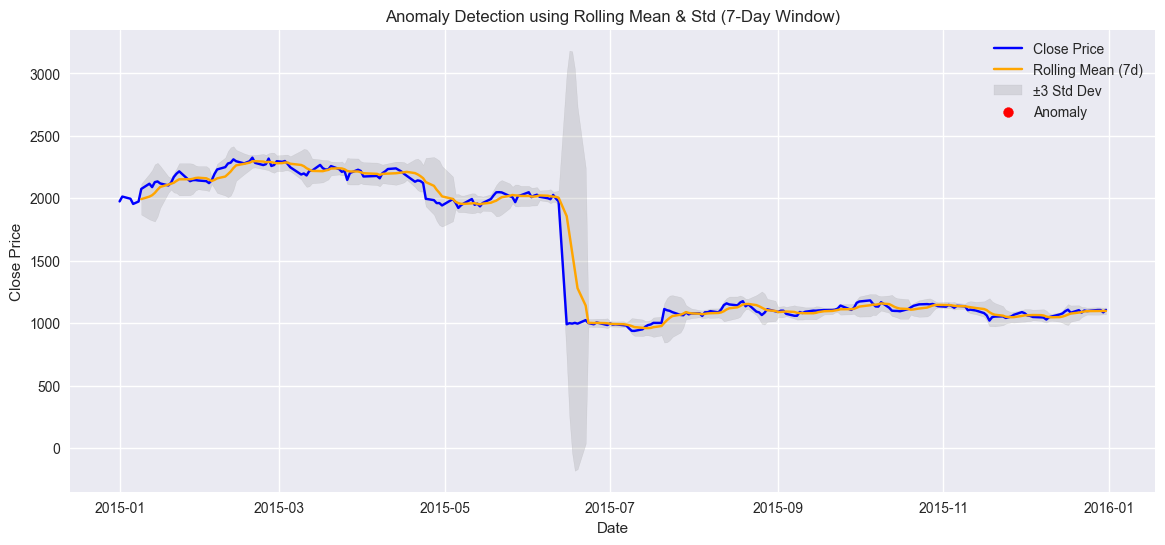

In [6]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Close"], label="Close Price", color='blue')
plt.plot(df.index, df["rolling_mean"], label="Rolling Mean (7d)", color='orange')
plt.fill_between(df.index, df["upper_band"], df["lower_band"], color='grey', alpha=0.2, label="±3 Std Dev")

# Plot anomalies
plt.scatter(df[df["rolling_anomaly"]].index,
            df[df["rolling_anomaly"]]["Close"],
            color='red', label="Anomaly", s=50)

plt.title("Anomaly Detection using Rolling Mean & Std (7-Day Window)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


### Z-Score Based Anomaly Detection

z = (Close - mean) / std
anomaly if |z| > 3


In [7]:
mean_close = df["Close"].mean()
std_close = df["Close"].std()

df["z_score"] = (df["Close"] - mean_close) / std_close

df["z_anomaly"] = df["z_score"].abs() > 3


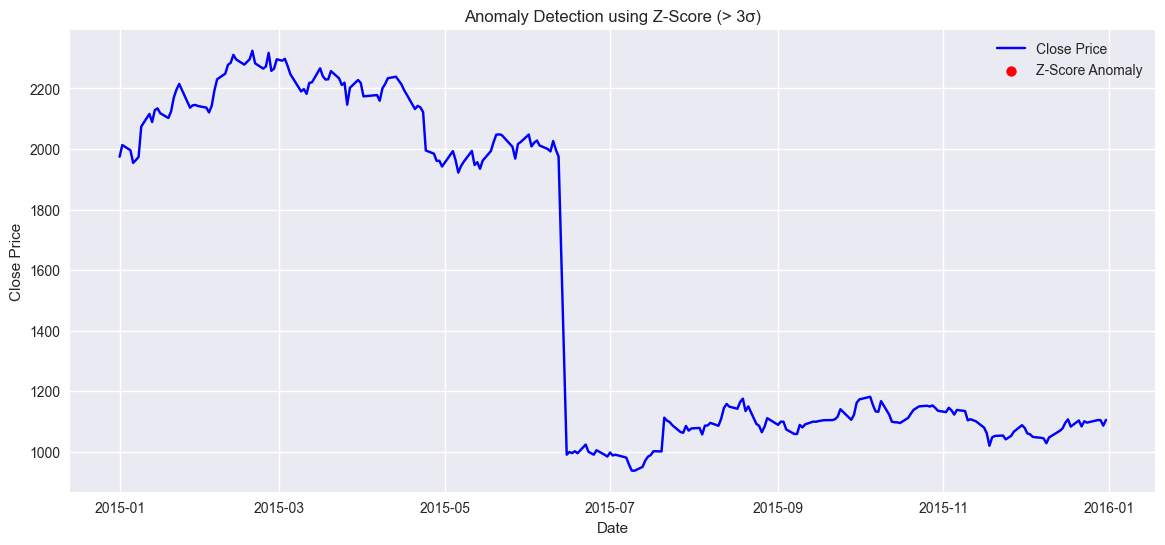

In [8]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Close"], label="Close Price", color='blue')

plt.scatter(df[df["z_anomaly"]].index,
            df[df["z_anomaly"]]["Close"],
            color='red', label="Z-Score Anomaly", s=50)

plt.title("Anomaly Detection using Z-Score (> 3σ)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


### IQR-Based Time Series Anomaly Detection

Lower bound = Q1 − 1.5×IQR
Upper bound = Q3 + 1.5×IQR


In [9]:
Q1 = df["Close"].quantile(0.25)
Q3 = df["Close"].quantile(0.75)
IQR = Q3 - Q1

lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR

df["iqr_anomaly"] = (df["Close"] < lower_iqr) | (df["Close"] > upper_iqr)


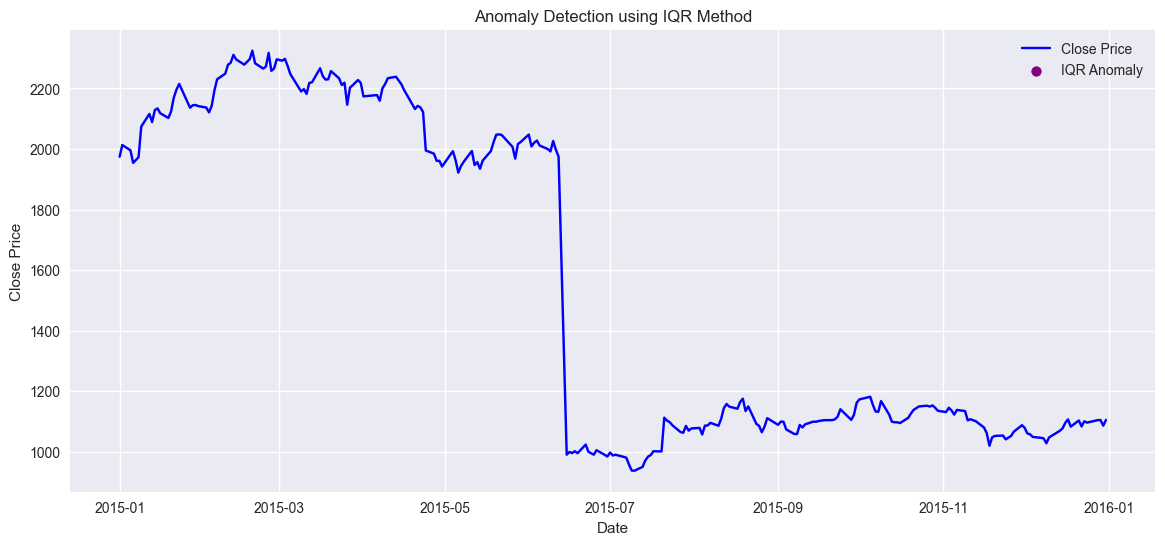

In [10]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Close"], label="Close Price", color='blue')

plt.scatter(df[df["iqr_anomaly"]].index,
            df[df["iqr_anomaly"]]["Close"],
            color='purple', label="IQR Anomaly", s=50)

plt.title("Anomaly Detection using IQR Method")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


### Comparison

In [11]:
summary = pd.DataFrame({
    "Method": ["Rolling Mean/Std", "Z-Score", "IQR"],
    "Anomalies Detected": [
        df["rolling_anomaly"].sum(),
        df["z_anomaly"].sum(),
        df["iqr_anomaly"].sum()
    ]
})

summary


,Method,Anomalies Detected
0,Rolling Mean/Std,0
1,Z-Score,0
2,IQR,0


### ✔ Manual Anomaly Detection

Visual inspection of the time series reveals sudden jumps/spikes.

Useful as baseline for more advanced methods.

### ✔ Rolling Mean & Rolling Std

Detects anomalies relative to recent volatility (7-day window).

Good for smooth or trending time series.

Detects short-term unusual spikes.

### ✔ Z-Score Method

Identifies global outliers using whole-series mean & std.

Best when data is stationary and normally distributed.

Might miss local anomalies but finds extreme global ones.

### ✔ IQR Method

Non-parametric (does not assume normal distribution).

Good for skewed or heavy-tailed price distributions.